## Setup

In [1]:
# imports
import os, threadpoolctl, psycopg2, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, hvplot.pandas
from dotenv import load_dotenv
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn import metrics
from sklearn.cluster import KMeans
from typing import List, Literal, Tuple, Union, Sequence

In [2]:
# stop leak message from modeling
#os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ['OMP_NUM_THREADS'] = '1'
threadpoolctl.threadpool_limits(1)

In [3]:
# database setup
db = 'order_mgmt'

# pull credentials from .env
load_dotenv('../.env')

dsn = f'''
dbname={db} 
user={os.getenv('super_user')} 
password={os.getenv('pg_password')} 
host={os.getenv('host')} 
port={os.getenv('port')}
'''

### Get data from database

In [4]:
# connect to database to create dataframe
with psycopg2.connect(dsn) as conn, conn.cursor() as cur:
    # get one record per purchase
    cur.execute(
        '''
        SELECT 	o.order_no,
		        o.customer_id,
                o.order_date,
                -- SUM(ol.quantity) AS total_quantity,
                SUM(ol.sales) AS total_sales
        FROM orders o
        JOIN order_lines ol USING (order_no)
        WHERE o.status IN 
            ('Shipped', 'Resolved')
        GROUP BY o.order_no, o.customer_id, o.order_date
        ORDER BY o.order_no
        '''
    )

    # fetch data
    records = cur.fetchall()
    fields = [field.name for field in cur.description]

    # setup dataframe
    df = pd.DataFrame(records, columns=fields)

In [5]:
# display data
df.head()

,order_no,customer_id,order_date,total_sales
0,10100,15,2003-01-06,12133.25
1,10101,51,2003-01-09,11432.34
2,10102,42,2003-01-10,6864.05
3,10103,65,2003-01-29,54702.00
4,10104,37,2003-01-31,44621.96


# Preprocessing
---

## Update data types

In [6]:
# data types
df.dtypes

order_no        int64
customer_id     int64
order_date     object
total_sales    object
dtype: object

In [7]:
# update data types
df.total_sales = pd.to_numeric(df.total_sales)
df.order_date = pd.to_datetime(df.order_date)

In [8]:
# double check dtypes
df.dtypes

order_no                int64
customer_id             int64
order_date     datetime64[ns]
total_sales           float64
dtype: object

## Get RFM (Recency, Frequency, Monetary)

For each customer:
- Recency: number of days between "present" date and date of last purchase
- Frequency: number of orders
- Monetary: sum of purchase price

In [9]:
# calculate recency, frequency, monetary for each customer
recent_date = df.order_date.max()
rfm_df = df.groupby('customer_id').agg({
    'order_date': lambda date: (recent_date - date.max()).days,
    'order_no': lambda orders: len(orders),
    'total_sales': lambda sale: sale.sum()
})

# update columns
rfm_cols = ['recency', 'frequency', 'monetary']
rfm_df.columns = rfm_cols
#rfm_df = rfm_df.reset_index()

# display
rfm_df.head()

,recency,frequency,monetary
customer_id,,,
1,183,3,118711.78
2,213,2,100306.58
3,188,4,119028.73
4,441,3,142874.25
5,132,4,120783.07


## Check outliers/distribution

#### **Analysis:**
Recency: mild right skew--> most customers bought at around same time 
- Outliers: 4 (upper) 
- Percentiles: 99th percentile is 1.08 times greater than 95th percentile
- Skew: 0.769 
- Mean > Median --> 189.05 > 181.0

Frequency: heavy right skew driven by a few very active/loyal customers (good to look into outliers since they more than triple the 95th percentile)
- Outliers: 5 (upper)  
- Percentiles: 99th percentile is 3.74 times greater than 95th percentile
- Skew: 6.138
- Mean > Median: 3.15 > 3.0

Monetary: heavy right skew with a few high spending customers (good to look into since they're four times the 95th percentile)
- Outliers: 4 (upper)
- Percentiles: 99th percentile is 4.01 times greater than 95th percentile
- Skew: 5.393
- Mean > Median: 102,632.82 > 85,360.0

OVERALL:
- Overall, all RFM measures are right skewed but mainly Frequency and Monetary driven by high activity/spenders; recency is only mildly skewed
- Keep outliers as they are valid and important to understand (transforming/scaling will prevent them from dominating before modeling)

#### Outliers

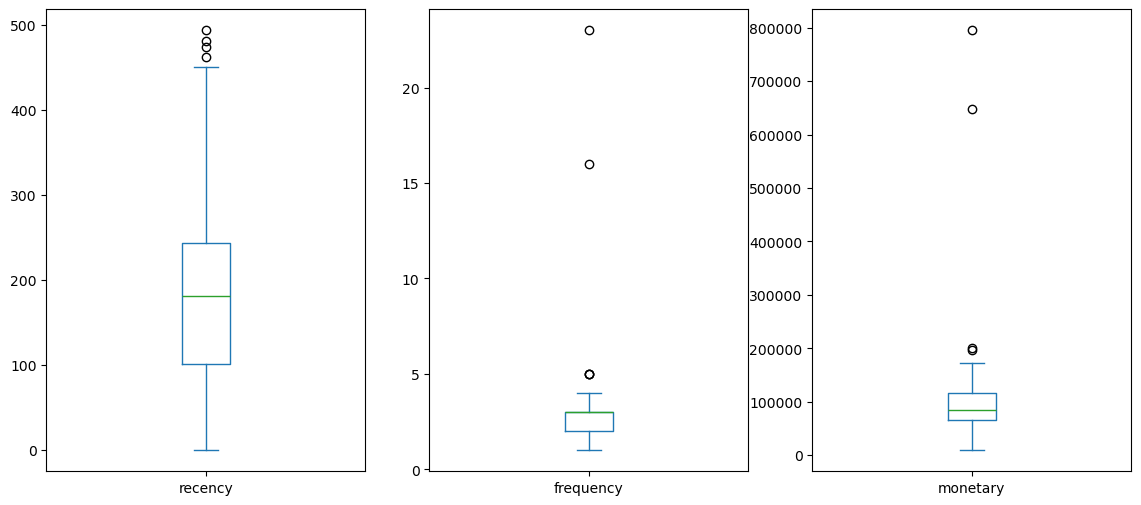

In [10]:
# boxplots
rfm_df.plot(kind='box', subplots=True, figsize=(14,6))
plt.show()

In [11]:
# number of outliers
for rfm_col in rfm_cols:
    # calculate iqr
    col = rfm_df[rfm_col]
    q1, q3 = col.quantile([.25, .75])
    iqr = q3 - q1

    # find outliers
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    l_outliers = (col < lower).sum()
    u_outliers = (col > upper).sum()

    # display
    print('-'*30)
    print(rfm_col.upper())
    print(f'\nNumber of outliers: {l_outliers + u_outliers}')
    print(f'Upper: {u_outliers}')
    print(f'Lower: {l_outliers}')
    print('-'*30)

------------------------------
RECENCY

Number of outliers: 4
Upper: 4
Lower: 0
------------------------------
------------------------------
FREQUENCY

Number of outliers: 5
Upper: 5
Lower: 0
------------------------------
------------------------------
MONETARY

Number of outliers: 4
Upper: 4
Lower: 0
------------------------------


### Distribution

In [12]:
# compare percentiles (mainly 95% and 99%)
percentiles = rfm_df.quantile([.25,.5,.75,.9,.95,.99])
display(percentiles)

for col in rfm_cols:

    # calculate top 1% and top 5%
    top_1 = percentiles.loc[0.99, col]
    top_5 = percentiles.loc[0.95, col]

    # display
    print(col.upper())
    print(f'top 1: {top_1}')
    print(f'top 5: {top_5}')
    print(f'99th percentile is {round(top_1/top_5,2)} times greater than 95th percentile')
    print('-'*30)

,recency,frequency,monetary
0.25,101.75,2.00,66129.0075
0.50,181.00,3.00,85360.0000
0.75,243.25,3.00,115616.8825
0.90,385.20,4.00,142846.9580
0.95,448.25,4.45,164639.6515
0.99,482.17,16.63,660892.1819


RECENCY
top 1: 482.1700000000001
top 5: 448.25
99th percentile is 1.08 times greater than 95th percentile
------------------------------
FREQUENCY
top 1: 16.630000000000024
top 5: 4.450000000000003
99th percentile is 3.74 times greater than 95th percentile
------------------------------
MONETARY
top 1: 660892.1819000005
top 5: 164639.65150000007
99th percentile is 4.01 times greater than 95th percentile
------------------------------


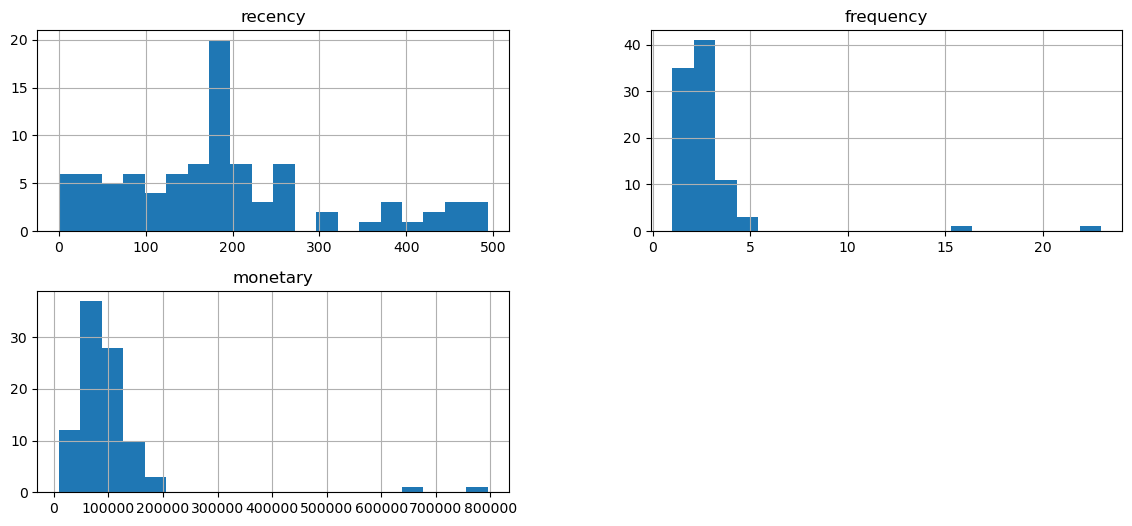

In [13]:
# histograms
rfm_df[rfm_cols].hist(bins=20, figsize=(14,6))
plt.show()

In [14]:
# find skewness and compare mean with median (mean > median --> right skew)
for col in rfm_cols:
    print(col.upper())
    print(f'Skewness: {rfm_df[col].skew()}')
    print(f'\nMean: {rfm_df[col].mean()}')
    print(f'Median: {rfm_df[col].median()}')
    print('-'*30)

RECENCY
Skewness: 0.7692197491282079

Mean: 189.05434782608697
Median: 181.0
------------------------------
FREQUENCY
Skewness: 6.138049494790223

Mean: 3.152173913043478
Median: 3.0
------------------------------
MONETARY
Skewness: 5.392615515812862

Mean: 102632.8191304348
Median: 85360.0
------------------------------


## Check correlation

**Analysis:** 
- <ins>Frequency & Monetary</ins> (r = 0.95) --> strong relationship where more frequent buyers spend more & vise versa
- <ins>Frequency & Recency</ins> (r = -0.35) --> mild relationship where more frequent a buyer, the more recent their last purchase & vise versa
- <ins>Monetary and Recency</ins> (r = -0.31) --> mild relationship where higher spending customers have purchased more recently and vise versa

Overall:
- There is multicollinearity--> recency gives independent information while frequency and monetary have high multicollinearity

In [15]:
# check correlation matrix
rfm_df.corr()

,recency,frequency,monetary
recency,1.000000,-0.347882,-0.309187
frequency,-0.347882,1.000000,0.953394
monetary,-0.309187,0.953394,1.000000


## Transforming & Scaling

### Transforming frequency & monetary

In [16]:
# function: get quick distribution view
def check_distribution(col, b_vs_a='before'):
    # before or after display
    if b_vs_a.upper() == 'BEFORE':
        print('before transformation...')
    else:
        print('after transformation...')
    
    # check skewness
    print(f'\nSkewness: {col.skew()}')

    # display histogram
    col.hist(bins=20)
    plt.show()

------------------------------FREQUENCY------------------------------
before transformation...

Skewness: 6.138049494790223


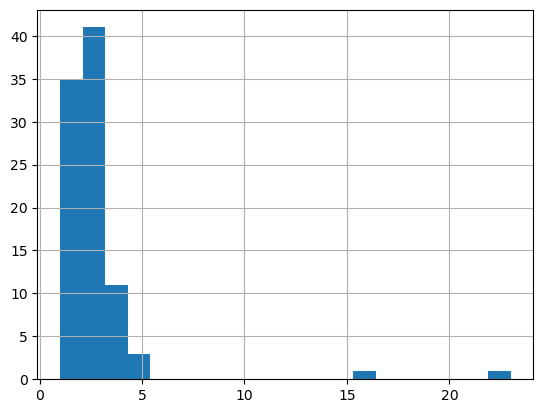

after transformation...

Skewness: -0.2567243779940801


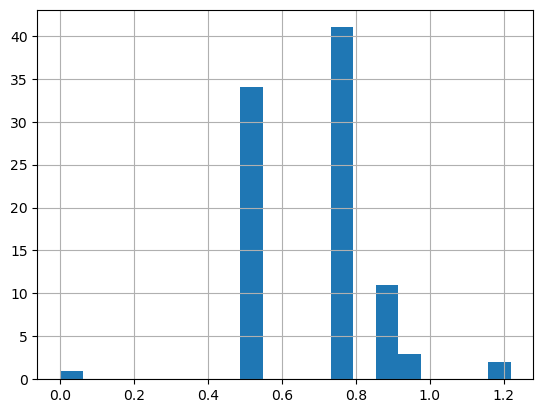

------------------------------MONETARY------------------------------
before transformation...

Skewness: 5.392615515812862


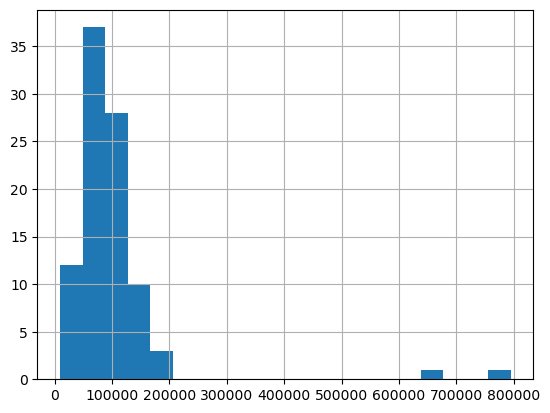

after transformation...

Skewness: 0.18604987274083093


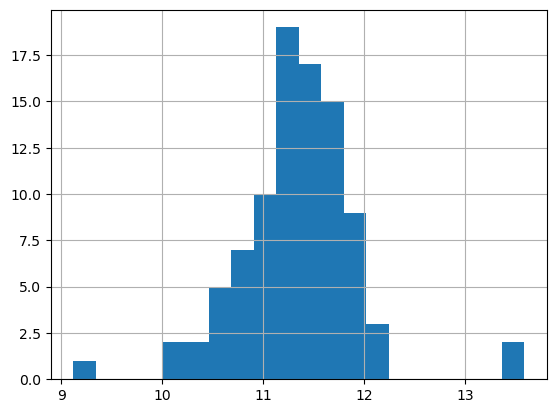

In [17]:
# set up new df
transformed_rfm_df = rfm_df.copy()

# transform columns accordingly
transformed_rfm_df['monetary'] = np.log1p(transformed_rfm_df['monetary'])
pt_frequency = PowerTransformer(method='box-cox', standardize=False)
transformed_rfm_df['frequency'] = pt_frequency.fit_transform(transformed_rfm_df[['frequency']])

# check og distributions vs new
for col_name in ['frequency', 'monetary']:
    print('-'*30 + col_name.upper() + '-'*30)
    check_distribution(rfm_df[col_name], b_vs_a='before')
    check_distribution(transformed_rfm_df[col_name], b_vs_a='after')

### Scale Data

Using RobustScaler, because it has low outlier sensitivity (ignores tails beyond IQR)

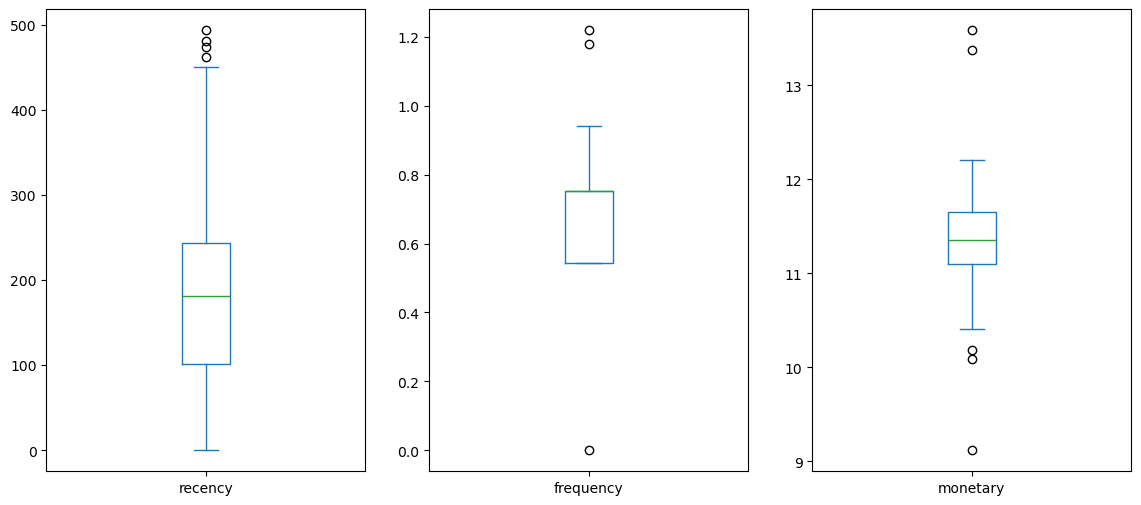

In [18]:
# quick outliers check
transformed_rfm_df.plot(kind='box', subplots=True, figsize=(14,6))
plt.show()

In [19]:
# normalize data
scaler = RobustScaler()
scaled_rfm = scaler.fit_transform(transformed_rfm_df)

In [20]:
# convert to df
scaled_rfm_df = pd.DataFrame(
    scaled_rfm,
    columns=rfm_cols,
    index=rfm_df.index
)

scaled_rfm_df.head()

,recency,frequency,monetary
customer_id,,,
1,0.014134,0.000000,0.590302
2,0.226148,-1.000000,0.288787
3,0.049470,0.548011,0.595074
4,1.837456,0.000000,0.921884
5,-0.346290,0.548011,0.621261


# Modeling
---

## Functions

In [106]:
# function: k means model
def get_k_model(
    k: int, 
    df: pd.DataFrame
):
    # fit k means model
    k_model = KMeans(n_clusters=k, init='k-means++', n_init=50, random_state=42)
    k_model.fit(df)

    # return
    return k_model

In [107]:
# function: elbow plot
def get_elbow_plot(main_df):
    # get copy of df
    df = main_df.copy()

    # get inertias for k vals
    inertias = []
    k_vals = list(range(1, 11))

    for k in k_vals:
        # fit k means model
        # k_model = KMeans(n_clusters=k, n_init=50, random_state=0)
        # k_model.fit(df)
        k_model = get_k_model(k, df)

        # save inertia
        inertias.append(k_model.inertia_)

    # save to df
    elbow_df = pd.DataFrame({
        'k': k_vals, 
        'inertia': inertias
    })

    # plot
    elbow_plot = elbow_df.hvplot.line(
        x='k',
        y='inertia',
        xticks=k
    )
    
    # return 
    return elbow_plot

In [108]:
# function: get best k value based on metric to do clusters and return segment labels and plot
def get_k_means_segments(
        scaled_data: pd.DataFrame,
        og_data: pd.DataFrame,
        k_values: List[int], 
        metric: Literal['silhouette', 'ch_score'] = 'silhouette', 
        x_val: str | None = None, 
        y_val: str | None = None
) -> Tuple[pd.DataFrame, 'hvplot.core.chart.Chart']:
    
    '''
    choose the best k by metric (silhouette or calinksi-harabasz), run k means, get segment labels, and return
        - dataframe with segment labels
        - scatter plot color coded by segment labels
    
    Parameters
    ----------
    scaled_data: scaled/transformed dataframe
    og_data: dataframe to attach predictions to and use for plotting (transformed or og data)
    k_values: list of potential number of segments
    metric: use silhouette or calinksi-harabasz score to get best number of segments
    x_val, y_val: optional features to plot in scatter plot (default select first two features in dataframe)
    '''
    # get copy of df
    df = scaled_data.copy()
    og_df = og_data.copy()

    # check df if it has minimum 2 cols and get axis for plot
    if x_val is None or y_val is None:
        if df.shape[1] < 2:
            raise ValueError(f'⚠ VALUE ERROR: DataFrame, {df}, must have at least 2 columns')
        cols = list(df.columns)
        x_val = x_val or cols[0]
        y_val = y_val or cols[1]

    
    # score all k values
    k_scores = []

    for k in k_values:
        # get scores
        k_model = get_k_model(k, df)
        labels = k_model.labels_

        # score based on metric selected
        if metric.lower() == 'silhouette':
            score = metrics.silhouette_score(df, labels)
        elif metric.lower() == 'ch_score':
            score = metrics.calinski_harabasz_score(df, labels)
        else:
            raise ValueError(f'⚠ VALUE ERROR: metric entered is "{metric}" when metric needs to be either: \n\tsilhouette \n\tch_score')
            
        k_scores.append({
            'k': k,
            'score': score
        })
        
    # display best score
    print(k_scores)
    top_k_score = max(k_scores, key=lambda item: item.get('score'))
    best_k, best_score = top_k_score['k'], top_k_score['score']
    print(f'Best k value = {best_k} ({metric} score = {best_score:.3f})')

    # get segments based on best k value
    # k_model = KMeans(n_clusters=best_k, n_init=50, random_state=0)
    # predictions = k_model.fit_predict(df)
    k_model = get_k_model(best_k, df)
    predictions = k_model.labels_
    #df['predictions'] = predictions

    # add labels to original dataframe
    labeled_og_df = og_df.assign(segment=predictions)

    # get scatter plot
    scatter_plot = labeled_og_df.hvplot.scatter(
        x=x_val,
        y=y_val,
        by='segment',
        hover_cols='all'
    )
    display(scatter_plot)

    # return df
    return labeled_og_df, scatter_plot

## With full scaled data

In [109]:
# see it's k = 3 or 4
get_elbow_plot(scaled_rfm_df)

:Curve   [k]   (inertia)

In [110]:
# select best k (3 or 4) but include 2 and 5 just in case
k_options = [2,3,4,5]
x_val = 'recency'
y_val = 'monetary'


# get segments for both metrics
print('SILHOUETTE SCORE'.center(150, '-'))
s_segments_df, s_segments_plot = get_k_means_segments(
    scaled_data=scaled_rfm_df, og_data=transformed_rfm_df, 
    k_values=k_options, metric='silhouette', x_val=x_val, y_val=y_val
)

print('CALINSKI HARABASZ SCORE'.center(150, '-'))
ch_segments_df, ch_segments_plot = get_k_means_segments(
    scaled_data=scaled_rfm_df, og_data=transformed_rfm_df, 
    k_values=k_options, metric='ch_score', x_val=x_val, y_val=y_val
)

-------------------------------------------------------------------SILHOUETTE SCORE-------------------------------------------------------------------
[{'k': 2, 'score': 0.40910663221363913}, {'k': 3, 'score': 0.43389384683890814}, {'k': 4, 'score': 0.44591393776542587}, {'k': 5, 'score': 0.4252379550048305}]
Best k value = 4 (silhouette score = 0.446)


:NdOverlay   [segment]
   :Scatter   [recency]   (monetary,customer_id,frequency,segment)

---------------------------------------------------------------CALINSKI HARABASZ SCORE----------------------------------------------------------------
[{'k': 2, 'score': 64.33816771615149}, {'k': 3, 'score': 56.1656851278826}, {'k': 4, 'score': 56.866433254066415}, {'k': 5, 'score': 58.84168364277497}]
Best k value = 2 (ch_score score = 64.338)


:NdOverlay   [segment]
   :Scatter   [recency]   (monetary,customer_id,frequency,segment)

## Without multicollinearity (only monetary or frequency)

### Recency & Monetary

In [111]:
# k is 3 or 4
cols = ['recency', 'monetary']
get_elbow_plot(scaled_rfm_df[cols])

:Curve   [k]   (inertia)

In [112]:
k_options = [2,3,4,5]
#cols = ['recency', 'monetary']


# get segments for both metrics
print('SILHOUETTE SCORE'.center(150, '-'))
s_segments_df, s_segments_plot = get_k_means_segments(
    scaled_data=scaled_rfm_df[cols], og_data=transformed_rfm_df,
    k_values=k_options, metric='silhouette'
)

print('CALINSKI HARABASZ SCORE'.center(150, '-'))
ch_segments_df, ch_segments_plot = get_k_means_segments(
    scaled_data=scaled_rfm_df[cols], og_data=transformed_rfm_df, 
    k_values=k_options, metric='ch_score'
)

-------------------------------------------------------------------SILHOUETTE SCORE-------------------------------------------------------------------
[{'k': 2, 'score': 0.4337782295921043}, {'k': 3, 'score': 0.4588957572938468}, {'k': 4, 'score': 0.45947146116531395}, {'k': 5, 'score': 0.3806610717314592}]
Best k value = 4 (silhouette score = 0.459)


:NdOverlay   [segment]
   :Scatter   [recency]   (monetary,customer_id,frequency,segment)

---------------------------------------------------------------CALINSKI HARABASZ SCORE----------------------------------------------------------------
[{'k': 2, 'score': 67.55615501238614}, {'k': 3, 'score': 59.06841551216313}, {'k': 4, 'score': 65.71807359121111}, {'k': 5, 'score': 76.4364754417785}]
Best k value = 5 (ch_score score = 76.436)


:NdOverlay   [segment]
   :Scatter   [recency]   (monetary,customer_id,frequency,segment)

### Recency & Frequency

In [113]:
cols = ['recency', 'frequency']
get_elbow_plot(scaled_rfm_df[cols])

:Curve   [k]   (inertia)

In [114]:
k_options = [2,3,4,5]
#cols = ['recency', 'frequency']


# get segments for both metrics
print('SILHOUETTE SCORE'.center(150, '-'))
s_segments_df, s_segments_plot = get_k_means_segments(
    scaled_data=scaled_rfm_df[cols], og_data=transformed_rfm_df,
    k_values=k_options, metric='silhouette'
)

print('CALINSKI HARABASZ SCORE'.center(150, '-'))
ch_segments_df, ch_segments_plot = get_k_means_segments(
    scaled_data=scaled_rfm_df[cols], og_data=transformed_rfm_df, 
    k_values=k_options, metric='ch_score'
)

-------------------------------------------------------------------SILHOUETTE SCORE-------------------------------------------------------------------
[{'k': 2, 'score': 0.5546091779179882}, {'k': 3, 'score': 0.5468970161282904}, {'k': 4, 'score': 0.5218983825867292}, {'k': 5, 'score': 0.5359261064462826}]
Best k value = 2 (silhouette score = 0.555)


:NdOverlay   [segment]
   :Scatter   [recency]   (frequency,customer_id,monetary,segment)

---------------------------------------------------------------CALINSKI HARABASZ SCORE----------------------------------------------------------------
[{'k': 2, 'score': 121.02061461641048}, {'k': 3, 'score': 104.02296447055114}, {'k': 4, 'score': 108.5955298856788}, {'k': 5, 'score': 114.21025770035112}]
Best k value = 2 (ch_score score = 121.021)


:NdOverlay   [segment]
   :Scatter   [recency]   (frequency,customer_id,monetary,segment)